# Challlenge - Brainomix

# Import Required Libraries

Let's upload some libraries:

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os, random, shutil
from PIL import Image, ImageDraw
from skimage.io import imread, imshow
from numpy import cumsum
import nibabel as nib

# Helpers function [1]

In [2]:
def find_pix_dim(ct_img):
    """
    Get the pixdim of the CT image.
    A general solution that gets the pixdim indicated from the image dimensions. From the last 2 image dimensions, we get their pixel dimension.
    Args:
        ct_img: nib image

    Returns: List of the 2 pixel dimensions
    """
    pix_dim = ct_img.header["pixdim"] # example [1,2,1.5,1,1]
    dim = ct_img.header["dim"] # example [1,512,512,1,1]
    max_indx = np.argmax(dim)
    pixdimX = pix_dim[max_indx]
    dim = np.delete(dim, max_indx)
    pix_dim = np.delete(pix_dim, max_indx)
    max_indy = np.argmax(dim)
    pixdimY = pix_dim[max_indy]
    return [pixdimX, pixdimY] # example [2, 1.5]

In [3]:
def compute_area(mask, pixdim):
    """
    Computes the area (number of pixels) of a binary mask and multiplies the pixels
    with the pixel dimension of the acquired CT image
    Args:
        lung_mask: binary lung mask
        pixdim: list or tuple with two values

    Returns: the lung area in mm^2
    """
    mask[mask >= 1] = 1
    lung_pixels = np.sum(mask)
    return lung_pixels * pixdim[0] * pixdim[1]

In [4]:
def create_mask_from_polygon(image, contours):
    """
    Creates a binary mask with the dimensions of the image and
    converts the list of polygon-contours to binary masks and merges them together
    Args:
        image: the image that the contours refer to
        contours: list of contours

    Returns:

    """
    lung_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1  # sanity check to make 100% sure that the mask is binary
    return lung_mask.T  # transpose it to be aligned with the image dims

# Settings 

First, we want to define the dimensions of the images as follow:

In [5]:
width = 1000 #HU
level = -600

We then create paths to access the images, an create a folder where we will store our masks.

In [6]:
original = 'Images/' #.nii.gz
final = 'Images_mask/' #<original name>_mask.nii.gz

In [7]:
if os.path.isdir(final): #if the mask folder already exists
    pass #do nothing
else: #otherwise
    os.mkdir(final) #create the folder with the appropriate directory

In [8]:
files = os.listdir(original) #We list all of the paths (to the images)

In [9]:
data_list = [] #list which will contain the 9 3D images 
data_index_3 = []
for file in files: #Iteration through all the images 
    
    if file != '.DS_Store': #not process the .DS_Store file
        
        img = nib.load(original + file) #load the image
        pix_dim = find_pix_dim(img) #get pixels dimensions for the conversion to ml 
        data = img.get_fdata() #get the data as an array
        data_list.append(data) #append this image 3D array to the list
        data_index_3.append(data.shape[2])
        print(data.shape) #print dimensions of 3D arrays


(512, 512, 33)
(512, 512, 29)
(512, 512, 17)
(512, 512, 33)
(512, 512, 21)
(512, 512, 29)
(768, 768, 25)
(512, 512, 21)
(512, 512, 17)


# Plot of a slice 

We want to ploat a slice of the lung to get an overview of the images we are working on:

In [10]:
image_test = data_list[0].T[12] #One slice of the lung

<Figure size 432x288 with 0 Axes>

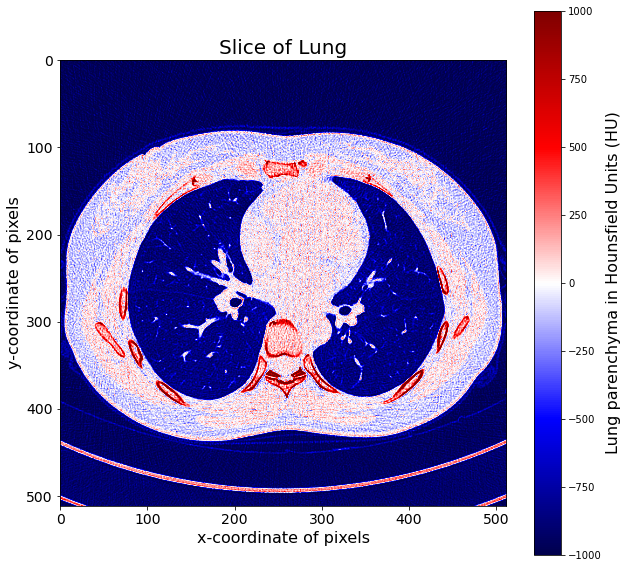

In [11]:
plt.figure(1)
plt.figure(figsize=(10,10))
plt.imshow(image_test,'seismic')
cbar = plt.colorbar()
plt.clim(-1000,1000) 
plt.title('Slice of Lung', fontsize=20)
plt.xlabel('x-coordinate of pixels', fontsize=16)
plt.ylabel('y-coordinate of pixels', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.ax.set_ylabel('Lung parenchyma in Hounsfield Units (HU)', fontsize=16)
plt.show()

# Task 1: For each image, let's segment the lung in the image and  and compute the lung volume in ml

## Binarize Image with threshold

len(data_list)len(data_list)Most normal lung parenchyma is below –300 HU and above –1000 HU. 

In [12]:
len(data_list[0].T)

33

In [13]:
data_list[0].T[1].shape

(512, 512)

In [14]:
binary_list = data_list #binary equivalent of the images
threshold = -300 #HU

for k in range(len(data_list)): #Index for the 3D image(9 images)
    #print(k)
    for l in range(len(data_list[k].T)): #Index for the slice of the image 
    
        for i in range(512): #Index for first coordinate of current slice of curent image

            for j in range(512): #Index for second coordinate of current slice of curent image

                if binary_list[k].T[l][i][j] < threshold:
                    binary_list[k].T[l][i][j] = 1

                else:
                    binary_list[k].T[l][i][j] = 0

Now that we have our equivalent list of binary 3D array, let's plot a "binary" slice of the lung to check our results

In [15]:
binary_slice_test = binary_list[0].T[12] #Image 1, slice 13 is used for this example

<Figure size 432x288 with 0 Axes>

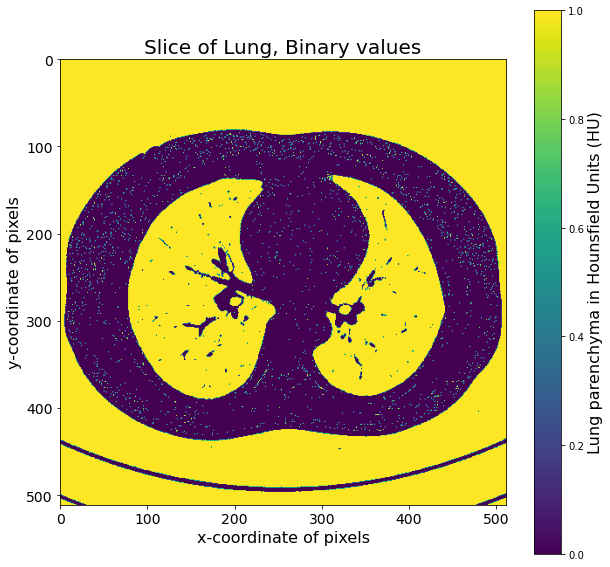

In [16]:
plt.figure(2)
plt.figure(figsize=(10,10))
plt.imshow(binary_slice_test)
cbar = plt.colorbar()
plt.clim(0,1) 
plt.title('Slice of Lung, Binary values', fontsize=20)
plt.xlabel('x-coordinate of pixels', fontsize=16)
plt.ylabel('y-coordinate of pixels', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar.ax.set_ylabel('Lung parenchyma in Hounsfield Units (HU)', fontsize=16)
plt.show()

## Get Contours of Binarized Image

From our binary data, we wan to extract the contour of the lungs. This will be used to later segment the lungs from the image.

In [17]:
from skimage import measure

In [18]:
contours_list = [] #List of all the contours for one full binary image

In [19]:
len(binary_list[2].T)

17

In [20]:
for i in range(len(binary_list)): #Index for the 3D image(9 images)
    
    for j in range(len(binary_list[i].T)): #Index for the slice of the image
        
        contours = measure.find_contours(binary_list[i].T[j], 0.95)
        contours_list.append(contours)
    

Below, an example of the contours of one slice from one image: 

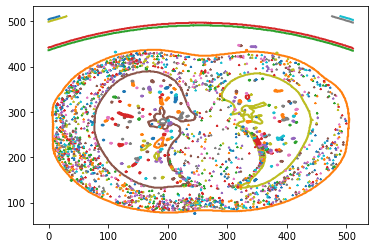

In [21]:
fig, ax = plt.subplots()

for contour in contours_list[0]:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

However, we only want to keep the contours of the lungs. therefore we need to remove the small contours and the ones representing g bowels, trachea, etc...

Let use a single threshold approach.

In [22]:
contours_list_lung = [x for x in contours_list] #List Comprehension to copy original list

if the value of the contour is too small we replace its value by a 2x2 zeros array

In [23]:
for i in range(len(contours_list)):
    for j in range(len(contours_list[i])):
        #print(j)
        if contours_list[i][j].shape[0] < 700: #Threshold
            contours_list_lung[i][j] = np.zeros((2, 2))

From the example below we can see that we still have two or one additional contours that we want to remove (the top one and the bottom one)

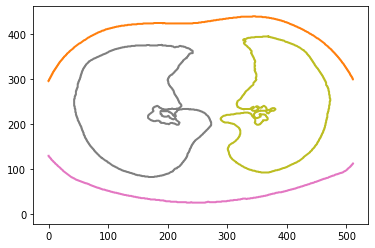

In [24]:
fig, ax = plt.subplots()

for contour in contours_list_lung[137]:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [25]:
max_height_list = [[]] * len(contours_list_lung)

for i in range(len(contours_list_lung)):
    
    for j in range(len(contours_list_lung[i])):
        
        if j == 0:

            max_height_list[i]= [np.amax(contours_list_lung[i][j][:,0])]
            
        else:
            
            max_height_list[i].append(np.amax(contours_list_lung[i][j][:,0]))
                


In [26]:
max_height_index_list = []
for i in range(len(max_height_list)):
    max_height_index_list.append(np.argmax(max_height_list[i]))

In [27]:
for j in range(len(contours_list_lung)):
    k = max_height_index_list[j]
    contours_list_lung[j].pop(k)

## Remove biggest contours that are not the lungs 

In [28]:
min_height_list = [[]] * len(contours_list_lung)

for i in range(len(contours_list_lung)):
    
    for j in range(len(contours_list_lung[i])):
        
        if j == 0:

            min_height_list[i]= [np.amin(contours_list_lung[i][j][:,0])]
            
        else:
            
            max_height_list[i].append(np.amin(contours_list_lung[i][j][:,0]))
                


In [29]:
min_height_index_list = []
for i in range(len(min_height_list)):
    min_height_index_list.append(np.argmin(np.nonzero(max_height_list[i])))

In [30]:
for j in range(len(contours_list_lung)):
    k = min_height_index_list[j]
    contours_list_lung[j].pop(k)

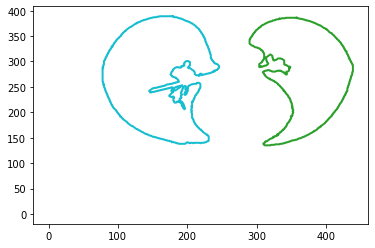

In [31]:
fig, ax = plt.subplots()

for contour in contours_list_lung[14]:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

## Create Lung Mask from Contours

In [32]:
num_img = len(data_list)
num_contour = len(contours_list_lung)

In [33]:
data_index_3 #Number of slices per image

[33, 29, 17, 33, 21, 29, 25, 21, 17]

In [34]:

lung_mask_list = [[[]]*data_index_3[0], [[]]*data_index_3[1], [[]]*data_index_3[2], [[]]*data_index_3[3], [[]]*data_index_3[4], [[]]*data_index_3[5], [[]]*data_index_3[6], [[]]*data_index_3[7], [[]]*data_index_3[8]]

In [35]:
data_index_3_cum_sum = cumsum(data_index_3 ) #cumulated sum of data_index_3

In [36]:
contour_list_lung_per_image = [0] * 9 #Each index holds the contour of one image

Now we assign the contours of an image to one location in the contour_list_lung_per_image list

In [37]:
contour_list_lung_per_image[0] = contours_list_lung[:data_index_3_cum_sum[0]]

for i in range(7):
    contour_list_lung_per_image[i+1] = contours_list_lung[data_index_3_cum_sum[i]:data_index_3_cum_sum[i + 1]]

contour_list_lung_per_image[8] = contours_list_lung[data_index_3_cum_sum[7]:]    

Finally, we create the mask for every slice of an image

In [39]:
for i in range(num_img):
    num_slices = len(data_list[i].T)    
    for j in range(num_slices):
                
        lung_mask = create_mask_from_polygon(data_list[i].T[j], contour_list_lung_per_image[i][j])
        lung_mask_list[i][j] = lung_mask

Example of a mask:

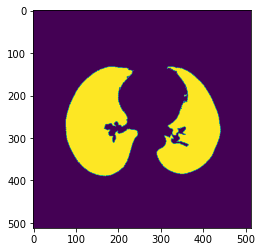

In [40]:
plt.imshow(lung_mask_list[0][0]) #Image index 0, slice index 0

In [41]:
lung_area = compute_area(lung_mask_list[0][0], pix_dim)

In [42]:
print('The Lung area is equal to: ' + str(lung_area) + ' mm^2')

The Lung area is equal to: 14780.74951171875 mm^2


Let's compute the volume for image index 0:

In [43]:
lung_are_slice = []

for i in range(data_index_3[0]):

    lung_area = compute_area(lung_mask_list[0][i], pix_dim)
    lung_are_slice.append(lung_area )

lung_volume = np.sum(lung_are_slice)

In [44]:
print('The Lung volume is equal to: ' + str(lung_volume) + ' mm^3')

The Lung volume is equal to: 483552.60009765625 mm^3


Therefore in ml:

In [45]:
lung_volume_ml = lung_volume*0.001
print('The Lung volume is equal to: ' + str(lung_volume_ml) + ' ml')

The Lung volume is equal to: 483.55260009765624 ml


# References:

[1] GitHub. 2022. GitHub - black0017/ct-intensity-segmentation: Introduction to medical image processing with Python: CT lung and vessel segmentation without labels https://theaisummer.com/medical-image-python/. [online] Available at: <https://github.com/black0017/ct-intensity-segmentation> [Accessed 24 January 2022].